In [7]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import mdtraj as md
import os, sys
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from importlib import reload
from cycler import cycler
from package.utils.utils import pmf
# source modules and classes being developed 


 # MI (several implementations) and Jaccard index code

In [20]:

def dirac_delta(x, states, weights=None):
    "'one hot' encoding of a (time) series of labels into a (n_samples, n_labels) binary matrix"
    x, states = (i.astype(int) for i in (x, states))
    impulse = (x.flatten() == states.reshape(-1, 1)).astype(float)
    return (impulse if weights is None else impulse * weights.reshape(1, -1)).T

def H(p, weight: bool = True):
    p = p[p != 0]
    p /= p.sum()
    return -np.sum(p * np.log2(p)) if weight else -np.sum(np.log2(p))


def adjust_min(x):
    x += 1e-8
    return x / x.sum()

from numpy_indexed import group_by as group_by_

def group_by(keys: np.ndarray,
             values: np.ndarray=None,
             reduction: callable=None):
    
    if reduction is not None:
        
        values = np.ones_like(keys) / len(keys) if values is None else values
        
        return np.asarray(group_by_(keys=keys, values=values, reduction=reduction))[:, -1]
    
    values = np.arange(len(values)) if values is None else values

    return group_by_(keys).split_array_as_list(values)

def cluster_similarity(dtraj0: np.ndarray,
                       dtraj1: np.ndarray,
                       weights_x: np.ndarray = None,
                       weights_y: np.ndarray = None,
                       min_count: int = None,
                       stationary: bool = False,
                       norm: bool = False):
    
    # get all unique states for both datasets
    
    states = np.intersect1d(dtraj0, dtraj1)

    if any(weights is not None for weights in (weights_x, weights_y)):

        """Pull out frames with zero weight, apply weights, update count matrix"""

        idx = np.prod(np.stack([~np.isclose(w, 0) for w in (weights_x, weights_y) if w is not None], 1), 1).astype(
            bool).flatten()

        #
        x0, x1 = (dirac_delta(x[idx], states) for x in (dtraj0, dtraj1))

        # get get non-empty bins before applying weights
        i, j = np.where(x0.T @ x1 != 0) if min_count is None else np.where(x0.T @ x1 >= min_count)

        x0, x1 = (x * w[idx].reshape(-1, 1) if w is not None else x
                  for x, w in zip((x0, x1), (weights_x, weights_y)))

        counts = x0.T @ x1

    else:

        x0, x1 = (dirac_delta(x, states) for x in (dtraj0, dtraj1))

        counts = x0.T @ x1

        i, j = np.where(counts != 0) if min_count is None else np.where(counts >= min_count)

    if norm:
        counts /= np.sum(counts[i, j])

    # pair list is SPARSE ; only non-zero indicies and probabilities are in the pair list
    pair_list = {(i, j): counts[i, j] for i, j in zip(i, j)}

    return counts, pair_list


def cluster_mi(x, y,
               weights_x: np.ndarray = None,
               weights_y: np.ndarray = None,
               min_count: int = None,
               shift_min: bool = False,
               stationary: bool = False,
               norm: str = "product"):
    
    """When working with the same dataset assigned two sets of labels, x and y,
       we compute the mutual information with many normalization options.
       For Stationary (non-paired datasets clustered in same geometric space over a fixed grid),
       a similarity metric in akin to mutual information can be computed using entropies of the distributions
       in the overlapping and non-overlapping regions of the two datasets.
       This describes the difference in distributions of the datasets in the
       overlapping and nonoverlapping regions but DOES NOT describe the extent to which the datasets overlap.
       For this reason, we also compute the Jaccard index for these datastes as measured by summing the
       densities of the overlapping regions and normalizing by the total number of points or combined weights.
       """

    
    if stationary:
        
        # find states common to both datasets
        states_xy = np.intersect1d(x, y)
                
        # concatenate state assignments
        xy  = np.concatenate((x, y))
        
        # concatenate weights
        weights_xy = np.concatenate([np.ones(len(i)) / len(i) if weights is None else weights
                                    for i, weights in zip((x, y), (weights_x, weights_y))])
        
        #normalize over all weights 
        weights_xy /= weights_xy.sum()
        
        # get indices of shared states
        ixy = np.isin(xy, states_xy)
        
        # sum weights of the states (bins / clusters) populated by both datasets
        jaccard_index = weights_xy[ixy].sum()
        
        
        px, py = (group_by(keys=i, values=weights, reduction=sum)
                  for i , weights in zip((x, y), (weights_x, weights_y)))
        
        Hx, Hy = (H(p) / np.log2(len(p)) for p in (px, py))
        
        pxy = group_by(keys=xy[ixy], values=weights_xy[ixy], reduction=sum)

        Hxy = H(pxy) / np.log2(len(states_xy))
        
        #d = (2 * Hxy - Hx - Hy) / (Hxy); similarity metric  = (1 - d)
        
        mi = Hx + Hy - Hxy
                
        print(f"Hx:{Hx},Hxy:{Hxy},Hy:{Hy}")
        
        print(f"MI : {Hx + Hy - Hxy}")
        
        
        return jaccard_index,  mi
        
    
    pxy, pij = cluster_similarity(x, y,
                                  weights_x=weights_x,
                                  weights_y=weights_y,
                                  min_count=min_count,
                                  norm=True)

    if shift_min:
        
        """add small amount to probabilities with zero weight.
           This avoids the need to remove bins from the distributions.
           Weights are renormalized after addition.
           As a result, we can do our math in matrix form :)
            """
        
        pxy = adjust_min(pxy)
        
        px, py = pxy.sum(1), pxy.sum(0)

        info = pxy * np.log2(np.diag(1 / px) @ pxy @ np.diag(1 / py))

    else:
        
        """Only consider non-zero bins. Renormalizes distributions after removing zeros.
           This gives same result as SKLearn but we can factor in weights using cluster
           similarity function"""
        
        keys = list(pij.keys())
        
        i, j = np.asarray(keys).T
        
        px, py = pxy.sum(1), pxy.sum(0)
        
        pij = np.fromiter(map(pij.__getitem__, keys), float)
        
        # ii, jj = map(np.unique, (i, j))
        # norm = 2 * len(pxy) if norm == "state" \
        #     else np.log2(len(x)) if norm == "sample" \
        #     else H(px[ii]) + H(py[jj]) if norm == "sum" \
        #     else 2 * np.sqrt(H(px[ii])) * np.sqrt(H(py[jj]))
    
        info = pij * np.log2(pij / (px[i] * py[j]))
    
    norm = 2 * len(pxy) if norm == "state" \
        else np.log2(len(x)) if norm == "sample" \
        else (H(px) + H(py)) / 2 if norm == "sum" \
        else np.sqrt(H(px)) * np.sqrt(H(py)) if norm == "product" \
        else max(H(px), H(py)) if norm == "max" \
        else min(H(px), H(py)) if norm == "min" \
        else H(pxy, weight=True) if norm == "joint" \
        else 1
        
    return info / norm

def jaccard_index(x, y, bins: int = 50):
    """convenience function, see cluster_mi"""
    xy = np.concatenate([x, y], 0)
    range_ = ((xy[:,0].min(), xy[:,0].max()), (xy[:,1].min(), xy[:,1].max()))
    dx, dy = (pmf(i, bins, range=range_)[-2] for i in (x,y))
    return cluster_mi(dx, dy, stationary=True)[0]

 # Sanity Check basic cases

In [21]:
x, y = (np.random.randint(0, 10, 1000) for i in range(2))
z = x 
from sklearn.metrics.cluster import normalized_mutual_info_score
print("SKLearn - independent samples", normalized_mutual_info_score(x, y))
print("Defined - indepdendent samples", cluster_mi(x, y, norm="sum").sum())
print("Add small amount to avoid zeros", cluster_mi(x, y, norm="sum", shift_min=True).sum())
print("SKLearn - dependent samples", normalized_mutual_info_score(x, z))
print("Defined - depdendent samples", cluster_mi(x, z, norm="sum").sum())
print("Add small amount to avoid zeros", cluster_mi(x, z, norm="sum", shift_min=True).sum())
#print(" \n User defined implementation improves SKLearn\n by adding weights option and a means for dealing\n with independent data via overlap integral")

SKLearn - independent samples 0.017081613449760426
Defined - indepdendent samples 0.017081613449760488
Add small amount to avoid zeros 0.017081578498386207
SKLearn - dependent samples 1.0
Defined - depdendent samples 1.0
Add small amount to avoid zeros 0.9999932971823058


 # More Nuanced case we're dealing with 

## For independently sampled clusterings that exist in the same geometric space, we can compute the overlap and weighted overlap of the probability densities if the clusterings are performed using the same grid (histogram bounds and bin widths). This is the (weighted) Jaccard index. We can also compute and compare the entropies of the distributions in overlapping and non-overlapping regions which let's us plug into the mutual information equation, 
 
 
 #                                           Hx + Hy - Hxy

Hx:0.9949181960408742,Hxy:0.9957360582362119,Hy:0.9951966582676631
MI : 0.9943787960723255
Hx:0.9883021191832803,Hxy:0.9932746743187084,Hy:0.9883459604681348
MI : 0.9833734053327068


Text(0.5, 1.5, "The following toy dataset is constructed such that the\ndistributions overlap with probability = 1/4 and the\nvariation of information approaches zero.i.e.the\n distributions don't change in the overlapping region")

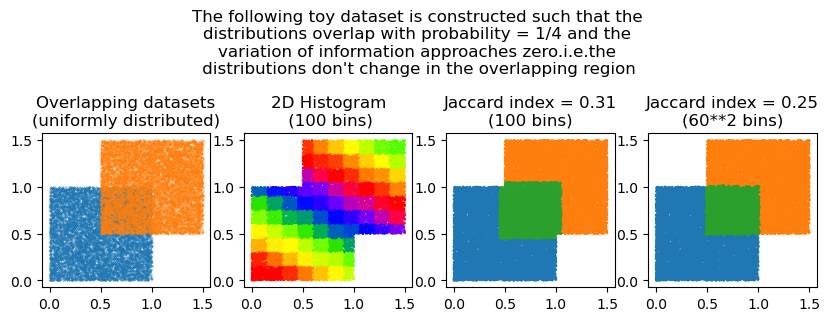

<Figure size 640x480 with 0 Axes>

In [22]:
# sample uniform distribution
x = np.stack([np.random.rand(10000) for i in range(2)], 1)
y = x + (1/2)
fig, axes = plt.subplots(1,4, figsize=(10, 2))
ax=axes.flat
xy = np.concatenate([x, y], 0)
range_ = ((xy[:,0].min(), xy[:,0].max()), (xy[:,1].min(), xy[:,1].max()))
dx, dy = (pmf(i, 10, range=range_)[-2] for i in (x,y))
dxy = np.concatenate([dx, dy])
states_xy = np.intersect1d(dx, dy)
alpha = np.isin(dxy, states_xy).astype(float)

ax[0].scatter(*x.T, s=0.1, )
ax[0].scatter(*y.T, s=0.1, )
ax[0].set_title("Overlapping datasets\n(uniformly distributed)")

ax[1].scatter(*xy.T, c=dxy, s=0.5, cmap="prism", alpha=1, )
ax[1].set_title("2D Histogram\n (100 bins)")

ax[2].scatter(*x.T, s=1, alpha = (~np.isin(dx, states_xy)).astype(float))
ax[2].scatter(*y.T, s=1, alpha=(~np.isin(dy, states_xy)).astype(float))
ax[2].scatter(*xy.T, alpha=alpha, s=1)
ax[2].set_title(f"Jaccard index = {jaccard_index(x, y, 10).round(2)}\n(100 bins)")

dx, dy = (pmf(i, 80, range=range_)[-2] for i in (x,y))
dxy = np.concatenate([dx, dy])
states_xy = np.intersect1d(dx, dy)
alpha = np.isin(dxy, states_xy).astype(float)

ax[3].scatter(*x.T, s=1, alpha = (~np.isin(dx, states_xy)).astype(float))
ax[3].scatter(*y.T, s=1, alpha=(~np.isin(dy, states_xy)).astype(float))
ax[3].scatter(*xy.T, alpha=alpha, s=1)
ax[3].set_title(f"Jaccard index = {jaccard_index(x, y, 60).round(2)}\n(60**2 bins)")
plt.figure()

fig.suptitle(("The following toy dataset is constructed such that the\n"
              "distributions overlap with probability = 1/4 and the\n"
              "variation of information approaches zero.i.e.the\n distributions "
              "don't change in the overlapping region"),
            y=1.5)

 # Weight the data with a gaussian kernel at the center of the overlap (3/4, 3/4) 

In [31]:
def kernel(x, center_scale=1, kernel_scale=1, fxn=None):
    mean = np.array([center_scale * (3/4)] * 2)
    d = np.linalg.norm(x-mean, axis=1)
    fxn = (lambda x : np.exp(-kernel_scale * x**2)) if fxn is None else fxn
    weights_x = fxn(d)
    return weights_x / weights_x.sum()
kernel(x)

array([7.44397641e-05, 1.26232301e-04, 9.85160963e-05, ...,
       8.31472083e-05, 8.73725320e-05, 1.16981776e-04])

Hx:0.9506170677390804,Hxy:0.9883732446900703,Hy:0.9527527527556111
MI : 0.9149965758046211
Hx:0.9682461471476811,Hxy:0.987027658121018,Hy:0.9671738522276967
MI : 0.9483923412543598
Hx:0.9410614922126201,Hxy:0.9796899327228079,Hy:0.9383645430185275
MI : 0.8997361025083397
Hx:0.9169810471843186,Hxy:0.9717117909107756,Hy:0.9137631764433805
MI : 0.8590324327169235


Text(0.5, 1.22, 'Gaussian weighted points with diverging means')

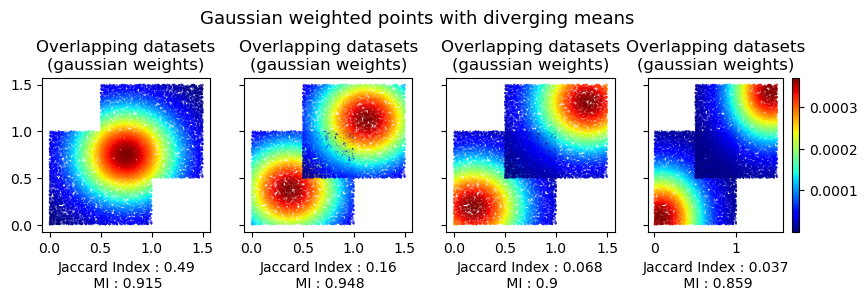

In [32]:
fig, axes = plt.subplots(1,4, figsize=(10,2), sharey=True)


x_center_scales = [1, .5, .25, .1]
y_center_scales = [1, 1.5, 1.75, 1.9]
for ax, x_center, y_center in zip(axes.flat, x_center_scales, y_center_scales):
    
    weights_x = kernel(x, center_scale=x_center, kernel_scale=4)
    weights_y = kernel(y, center_scale=y_center, kernel_scale=4)
    ax.scatter(*x.T, s=0.1,c=weights_x , cmap="jet")
    s=ax.scatter(*y.T, s=0.1,c=weights_y, cmap="jet" )
    
    jaccard, similarity = cluster_mi(dx, dy,
                                     weights_x=weights_x,
                                     weights_y=weights_y, 
                                     stationary=True)
    
    ax.set_xlabel(f"Jaccard Index : {jaccard.round(3)}\n MI : {similarity.round(3)}")
    ax.set_title("Overlapping datasets\n(gaussian weights)")

plt.colorbar(s, ax=ax)
fig.suptitle("Gaussian weighted points with diverging means", y=1.22, fontsize=13)


Hx:0.9804609544328828,Hxy:0.9880913615071306,Hy:0.9411697210444846
MI : 0.9335393139702367
Hx:0.9835750173959732,Hxy:0.9834032884028888,Hy:0.9426991342780521
MI : 0.9428708632711363
Hx:0.9837003926189355,Hxy:0.9817930029658396,Hy:0.8786409988830275
MI : 0.8805483885361235
Hx:0.8304275381708541,Hxy:0.8599028735168203,Hy:0.8267253452968896
MI : 0.7972500099509235
Hx:0.8494594390111062,Hxy:0.9900862068601921,Hy:0.8456164736846808
MI : 0.704989705835595
Hx:0.9740289091022666,Hxy:0.9827801347889465,Hy:0.9752190074328498
MI : 0.9664677817461699


Text(0.5, 1.22, 'Gaussian weighted points with diverging SDs and means')

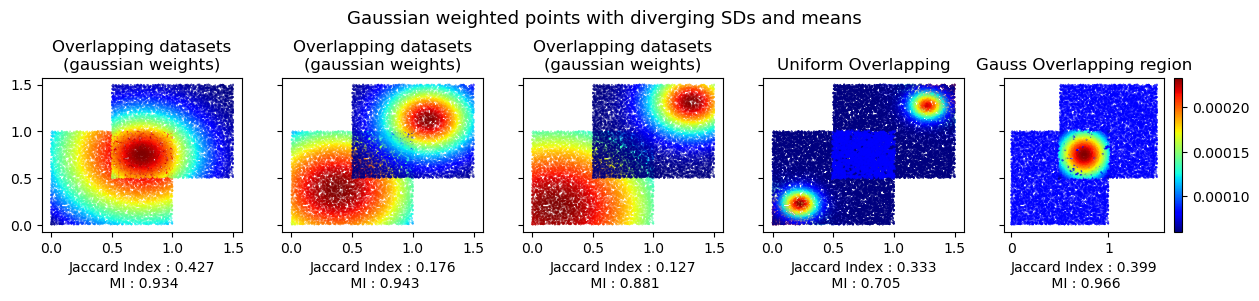

In [60]:
fig, axes = plt.subplots(1,5, figsize=(15,2), sharey=True)

x_kernel_scales = [1, .5, .25, 9.5]
y_kernel_scales = [1, 1.5, 1.75, 1.9]
x_center_scales = [1, .5, .25, .1 ]
y_center_scales = [1, 1.5, 1.75, 1.9]

for ax, x_kernel, y_kernel, x_center, y_center in zip(axes.flat[:4],
                                                      x_kernel_scales,
                                                      y_kernel_scales,
                                                      x_center_scales,
                                                      y_center_scales):
    
    weights_x = kernel(x, kernel_scale=x_kernel, center_scale=x_center)
    weights_y = kernel(y, kernel_scale=5*y_kernel, center_scale=y_center)
    ax.scatter(*x.T, s=0.1,c=weights_x , cmap="jet")
    s=ax.scatter(*y.T, s=0.1,c=weights_y, cmap="jet" )
    
    jaccard, similarity = cluster_mi(dx, dy,
                                     weights_x=weights_x,
                                     weights_y=weights_y, 
                                     stationary=True)
    
    ax.set_xlabel(f"Jaccard Index : {jaccard.round(3)}\n MI : {similarity.round(3)}")
    ax.set_title("Overlapping datasets\n(gaussian weights)")
    

weights_x = kernel(x,  center_scale=.3, kernel_scale=50,)# fxn=lambda x : (100*np.cos(x*5))**2)
weights_y = kernel(y, center_scale=1.7, kernel_scale=50,)#fxn=lambda x : (100*np.cos(x*5))**2)
ixy = alpha.astype(bool)
weights = np.concatenate([weights_x, weights_y])
weights[ixy] = kernel(xy[ixy], kernel_scale=.1)
weights /= weights.sum() / 2
weights_x, weights_y = np.array_split(weights, 2)
s=axes[-2].scatter(*xy.T, s=0.1, c=weights, cmap="jet")

jaccard, similarity = cluster_mi(dx, dy,
                                 weights_x=weights_x,
                                 weights_y=weights_y, 
                                 stationary=True)

axes[-2].set_xlabel(f"Jaccard Index : {jaccard.round(3)}\n MI : {similarity.round(3)}")
axes[-2].set_title("Uniform Overlapping") 
    
weights_x = kernel(x,  center_scale=.5, kernel_scale=1/10)
weights_y = kernel(y, center_scale=1.5, kernel_scale=1/10)
ixy = alpha.astype(bool)
weights = np.concatenate([weights_x, weights_y])
weights[ixy] = kernel(xy[ixy], kernel_scale=10)
weights /= weights.sum() / 2
weights_x, weights_y = np.array_split(weights, 2)
s=axes[-1].scatter(*xy.T, s=0.1, c=weights , cmap="jet")
jaccard, similarity = cluster_mi(dx, dy,
                                 weights_x=weights_x,
                                 weights_y=weights_y, 
                                 stationary=True)

axes[-1].set_xlabel(f"Jaccard Index : {jaccard.round(3)}\n MI : {similarity.round(3)}")
axes[-1].set_title("Gauss Overlapping region")

plt.colorbar(s, ax=axes[-1])
fig.suptitle("Gaussian weighted points with diverging SDs and means", y=1.22, fontsize=13)